**План ноутбука**

В этом ноутбуке мы перейдем от очищенных транзакций к аналитике. Сначала выгрузим заранее подготовленные данные, созданные в предудыщем ноутбуке и создадим базовые поля для агрегирования по времени. Далее рассчитаем ключевые KPI по месяцам (выручка, количество заказов, активные клиенты, средний чек) и визуализируем их динамику, чтобы увидеть сезонность и изменения спроса.

Следующий шаг — когортный анализ: определим месяц первой покупки для каждого клиента, рассчитаем индекс “месяцев с первой покупки” и построим матрицу удержания, которая покажет, как клиенты возвращаются со временем.

Затем выполним RFM-анализ: для каждого клиента считаем Recency, Frequency и Monetary, переведем показатели в оценки (1–5) и на основе правил сформируем сегменты (Champions, Loyal, At Risk и т.д.). В конце объединим сегменты с транзакциями и собирем сводную таблицу по сегментам (клиенты, заказы, выручка, AOV, доля выручки), чтобы подготовить базу для следующего ноутбука со статистикой, ML и рекомендациями.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузим очищенный датасет, который оформили в предыдущем ноутбуке
df = pd.read_csv('/Users/natan/ecom-transaction-growth-analysis/data/online_retail_II_cleaned.csv')
# Переведем дату в стандартный тип данных
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Создадим датасет с месячным KPI, сгруппируя данные
monthly_kpi = df.groupby('Month', as_index=False).agg(Revenue = ('Revenue','sum'),
Orders = ('Invoice','nunique'),
ActiveCustomers = ('Customer_ID','nunique'))

# Добавим столбцы с метриками: AOV и RPC
monthly_kpi['AOV'] = monthly_kpi['Revenue'] / monthly_kpi['Orders']
monthly_kpi['Revenue_per_customer '] = monthly_kpi['Revenue'] / monthly_kpi['ActiveCustomers']
monthly_kpi

,Month,Revenue,Orders,ActiveCustomers,AOV,Revenue_per_customer
0,2009-12-01,686654.160,1512,955,454.136349,719.009592
1,2010-01-01,557319.062,1011,720,551.255254,774.054253
2,2010-02-01,506371.066,1104,772,458.669444,655.921070
3,2010-03-01,699608.991,1524,1057,459.061018,661.881732
4,2010-04-01,594609.192,1329,942,447.410980,631.219949
5,2010-05-01,599985.790,1377,966,435.719528,621.103302
6,2010-06-01,639066.580,1497,1041,426.898183,613.896811
7,2010-07-01,591636.740,1381,928,428.411832,637.539591
8,2010-08-01,604242.650,1293,911,467.318368,663.274040
9,2010-09-01,831615.001,1689,1145,492.371226,726.301311


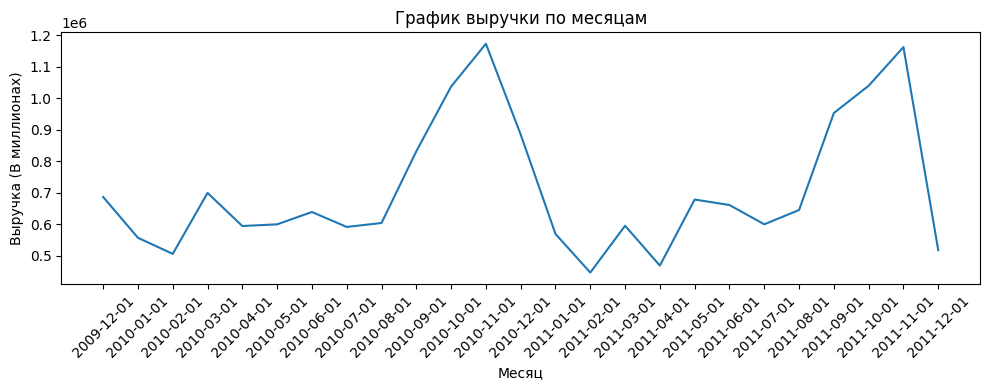

In [ ]:
# Построим график
plt.figure(figsize=(10,4))
plt.plot(monthly_kpi['Month'], monthly_kpi['Revenue'])
plt.title('График выручки по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Выручка (В миллионах)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


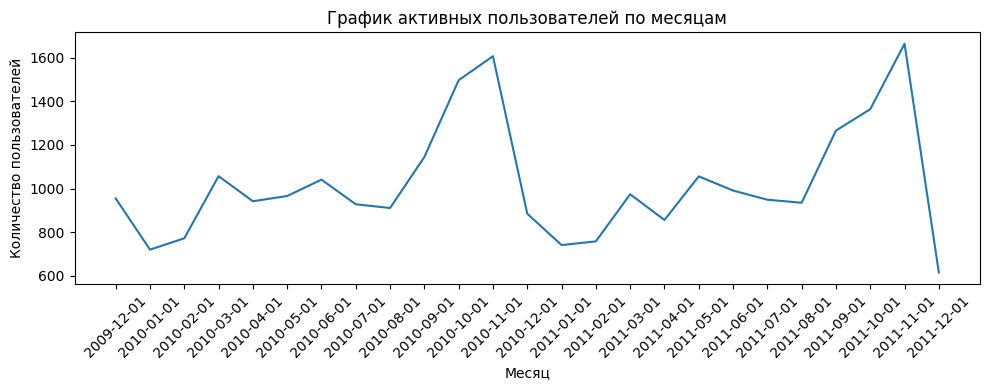

In [ ]:
# Построим график
plt.figure(figsize=(10,4))
plt.plot(monthly_kpi['Month'], monthly_kpi['ActiveCustomers'])
plt.title('График активных пользователей по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество пользователей')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

In [ ]:
# Проведем когортный анализ
# Оставим необходимые для этого столбцы
cohort_df = df[['Customer_ID','Invoice','InvoiceDate','Month']].copy()

# Сгруппируем данные для построения матрицы
cohort_df['Cohort_month'] = (
    cohort_df.groupby('Customer_ID')['InvoiceDate']
    .transform('min')
    .dt.to_period('M')
    .astype('str')
)
# Добавим необходимые столбцы
cohort_df['Order_month'] = cohort_df['InvoiceDate'].dt.to_period('M')
cohort_df['Cohort_month_period'] = pd.PeriodIndex(cohort_df['Cohort_month'], freq='M')

# Добавим когортный индекс для дальнейшего построения матрицы
cohort_df['Cohort_index'] = (
    (cohort_df['Order_month'] - cohort_df['Cohort_month_period'])
    .apply(lambda x: x.n)
)

In [ ]:
# Посчитаем сколько уникальных клиентов есть в каждой когорте
cohort_counts = (
    cohort_df.groupby(['Cohort_month', 'Cohort_index'])['Customer_ID']
             .nunique()
             .reset_index(name='N_customers')
)
# Преобразуем таблицу в матрицу
cohort_pivot = cohort_counts.pivot(index='Cohort_month', columns='Cohort_index', values='N_customers')

# Размер каждой когорты
cohort_size = cohort_pivot[0]

# Посчитаем долю вернувшихся, разделив каждую строку матрицы на размер когорты
retention = cohort_pivot.divide(cohort_size, axis = 0)
retention.head()

Cohort_index,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Cohort_month,,,,,,,,,,,,,,,,,,,,,
2009-12,1.0,0.352880,0.334031,0.425131,0.380105,0.359162,0.376963,0.342408,0.336126,0.362304,...,0.302618,0.262827,0.302618,0.282723,0.259686,0.255497,0.315183,0.304712,0.407330,0.196859
2010-01,1.0,0.206266,0.310705,0.305483,0.263708,0.300261,0.258486,0.229765,0.279373,0.318538,...,0.151436,0.234987,0.198433,0.185379,0.195822,0.242820,0.193211,0.245431,0.057441,NaN
2010-02,1.0,0.237968,0.224599,0.291444,0.245989,0.200535,0.192513,0.286096,0.254011,0.275401,...,0.200535,0.160428,0.163102,0.144385,0.229947,0.229947,0.163102,0.058824,NaN,NaN
2010-03,1.0,0.189616,0.230248,0.241535,0.232506,0.203160,0.246050,0.302483,0.275395,0.108352,...,0.169300,0.173815,0.155756,0.176072,0.200903,0.212190,0.079007,NaN,NaN,NaN
2010-04,1.0,0.193878,0.193878,0.163265,0.183673,0.224490,0.275510,0.261905,0.105442,0.108844,...,0.156463,0.139456,0.149660,0.180272,0.224490,0.057823,NaN,NaN,NaN,NaN


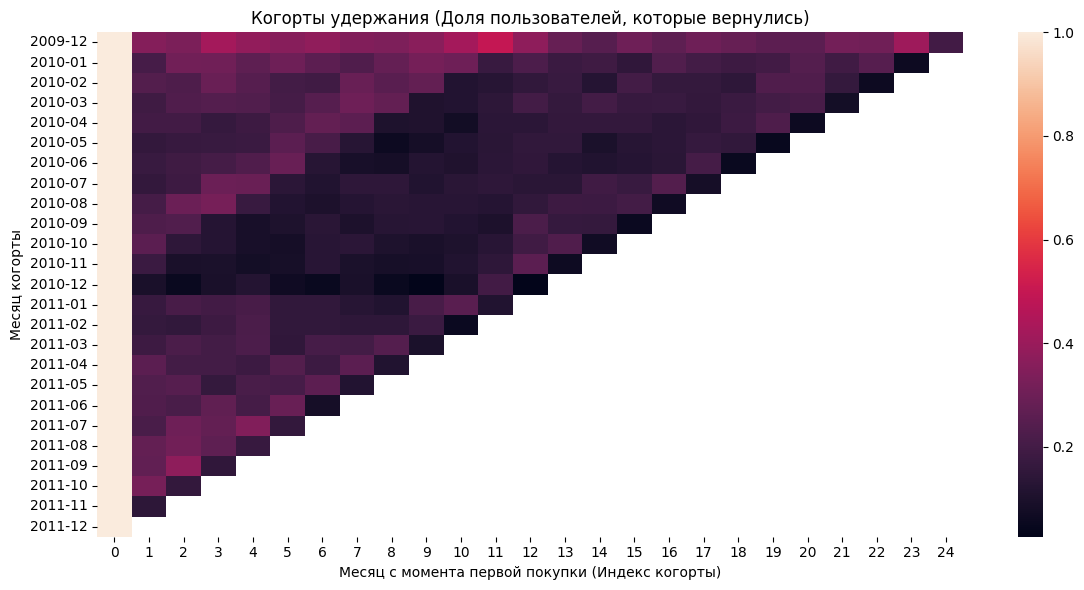

In [22]:
# Построим матрицу когортного анализа

plt.figure(figsize=(12,6))
sns.heatmap(retention, annot=False)
plt.title('Когорты удержания (Доля пользователей, которые вернулись)')
plt.xlabel('Месяц с момента первой покупки (Индекс когорты)')
plt.ylabel('Месяц когорты')
plt.tight_layout()
plt.show()

In [ ]:
# Возьмем копию данных, чтобы не менять исходный датасет
rfm_df = df.copy()

# Расчитаем давность покупки, взяв максимальную дату покупки + 1 день, чтобы у последней покупки Recency был 1 день
snapshot_date = rfm_df['InvoiceDate'].max() + pd.Timedelta(days = 1)

# Посчитаем RFM по каждому клиенту
rfm = (
    rfm_df.groupby('Customer_ID')
          .agg(
              Recency=('InvoiceDate', lambda x: (snapshot_date - x.max()).days),
              Frequency=('Invoice', 'nunique'),
              Monetary=('Revenue', 'sum')
          )
          .reset_index()
)
rfm.head()

,Customer_ID,Recency,Frequency,Monetary
0,12346,326,12,77556.46
1,12347,2,8,5633.32
2,12348,75,5,2019.40
3,12349,19,4,4428.69
4,12350,310,1,334.40


In [ ]:
# Посчитаем R_score: разбиваем Recency на 5 групп. Чем меньше Recency, тем свежее клиент, поэтому метки идут в обратном порядке
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)
# Посчитаем F_score: разбиваем Frequency на 5 групп. Чем больше Frequency, тем лучше, поэтому метки идут в обычном порядке
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
# Посчитаем M_score: Чем больше Monetary, тем лучше
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5]).astype(int)
# Склеим показатели для удобной сортировки и сегментации
rfm['RFM_score'] = rfm['R_score']*100 + rfm['F_score']*10 + rfm['M_score']

rfm.head()

,Customer_ID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_score
0,12346,326,12,77556.46,2,5,5,255
1,12347,2,8,5633.32,5,4,5,545
2,12348,75,5,2019.40,3,4,4,344
3,12349,19,4,4428.69,5,3,5,535
4,12350,310,1,334.40,2,1,2,212


In [ ]:
# Напишем функцию для сегментации клиента

def rfm_segment(row):
    # Берем оценки клиента
    r, f, m = row['R_score'], row['F_score'], row['M_score']
    # Champions: очень свежие, часто покупают и много тратят
    if (r >= 4) and (f >= 4) and (m >= 4):
        return 'Champions'
    # Loyal: часто покупают и относительно свежие
    if (r >= 3) and (f >= 4):
        return 'Loyal'
    # New customers: недавно покупали, но пока покупают редко
    if (r >= 4) and (f <= 2):
        return 'New customers'
    # At risk: давно не покупали, но раньше покупали часто
    if (r <= 2) and (f >= 3) and (m >= 3):
        return 'At Risk'
    # Hibernating: давно не покупали и до этого покупали редко
    if (r <= 2) and (f <= 2):
        return 'Hibernating'
    # Potential: потенциальные покупатели (усредненные показатели)
    return 'Potential'

# Применим функцию к столбцам и посчитаем сколько клиентов в каждом сегменте 
rfm['Segment'] = rfm.apply(rfm_segment, axis = 1)
rfm['Segment'].value_counts()

Segment
Hibernating      1523
Champions        1300
Potential        1299
Loyal             698
At Risk           615
New customers     443
Name: count, dtype: int64

In [ ]:
# Добавим к каждой транзакции сегмент клиента
df_seg = df.merge(rfm[['Customer_ID', 'Segment']], on='Customer_ID', how='left')

# Строим сводную таблицу по сегментам
segment_summary = (
    df_seg.groupby('Segment')
          .agg(
              Customers=('Customer_ID', 'nunique'),
              Revenue=('Revenue', 'sum'),
              Orders=('Invoice', 'nunique')
          )
          .reset_index()
)

# Добавим метрики
segment_summary['AOV'] = segment_summary['Revenue'] / segment_summary['Orders']
segment_summary['Revenue_share'] = segment_summary['Revenue'] / segment_summary['Revenue'].sum()

# Отсортируем данные
segment_summary.sort_values('Revenue', ascending=False)

,Segment,Customers,Revenue,Orders,AOV,Revenue_share
1,Champions,1300,1.212812e+07,22216,545.918057,0.683527
3,Loyal,698,1.886075e+06,5393,349.726572,0.106297
0,At Risk,615,1.548099e+06,3457,447.815682,0.087249
5,Potential,1299,1.119379e+06,3348,334.342552,0.063087
2,Hibernating,1523,6.671219e+05,1908,349.644613,0.037598
4,New customers,443,3.946386e+05,647,609.951484,0.022241


In [ ]:
# Сохраним полученные датасеты

monthly_kpi.to_csv('/Users/natan/ecom-transaction-growth-analysis/data/kpi_monthly.csv', index=False)

retention.reset_index().to_csv('/Users/natan/ecom-transaction-growth-analysis/data/retention_matrix.csv', index=False)

rfm.to_csv('/Users/natan/ecom-transaction-growth-analysis/data/rfm_customers.csv', index=False)

segment_summary.to_csv('/Users/natan/ecom-transaction-growth-analysis/data/segment_summary.csv', index=False)

